# 图结构可视化

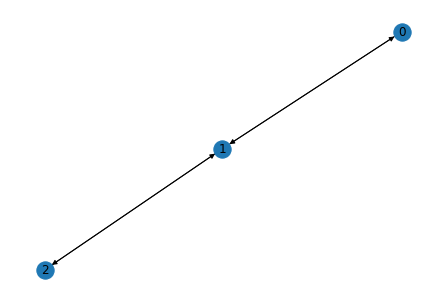

In [13]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import convert
from networkx import draw_kamada_kawai
import matplotlib.pyplot as plt

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

dg = convert.to_networkx(data)
draw_kamada_kawai(dg,with_labels=True)
plt.show()


In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import Data
from networkx import draw_kamada_kawai


edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)




# 自定义数据集